In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image

import config  # ✅ will work if notebook is in same folder as config.py
from data.dataset import UnifiedImageDataset

In [3]:
df = pd.read_csv(config.CSV_PATH)
df.shape

# load histograms
# rgb = np.load(config.COLOR_HIST_PATH_RGB)
# # lab_512 = np.load(config.COLOR_HIST_PATH_LAB)
# lab_514 = np.load(config.COLOR_HIST_PATH_LAB_514)
# # hcl_512 = np.load(config.COLOR_HIST_PATH_HCL)
# hcl_514 = np.load(config.COLOR_HIST_PATH_HCL_514)

# print("Shapes:", df.shape, rgb.shape, lab_514.shape, hcl_514.shape)

(2080, 6)

In [ ]:
# import pandas as pd, os, shutil, tempfile

# csv_path = "/data/thesis/coco_manifest.csv"   # <- your config.CSV_PATH
# backup   = csv_path + ".bak"

# # 1) Backup once
# if not os.path.exists(backup):
#     shutil.copy2(csv_path, backup)

# # 2) Load, replace (no reordering), write to a temp file first
# df = pd.read_csv(csv_path)
# before = (df["local_path"].str.contains("/data/thesis/coco2017/")).sum()

# df["local_path"] = df["local_path"].str.replace("coco2017", "coco", regex=False)

# after = (df["local_path"].str.contains("/data/thesis/coco2017/")).sum()

# # 3) Save atomically
# tmp = tempfile.NamedTemporaryFile("w", delete=False, dir=os.path.dirname(csv_path), suffix=".csv")
# df.to_csv(tmp.name, index=False)
# tmp.close()
# os.replace(tmp.name, csv_path)

# print(f"Replaced {before - after} paths. Backup at: {backup}")

Replaced 616767 paths. Backup at: /data/thesis/coco_manifest.csv.bak


In [3]:
df.head()

,split,image_id,file_name,local_path,caption
0,train,203564,000000203564.jpg,/data/thesis/coco/images/train2017/00000020356...,A bicycle replica with a clock as the front wh...
1,train,322141,000000322141.jpg,/data/thesis/coco/images/train2017/00000032214...,A room with blue walls and a white sink and door.
2,train,16977,000000016977.jpg,/data/thesis/coco/images/train2017/00000001697...,A car that seems to be parked illegally behind...
3,train,106140,000000106140.jpg,/data/thesis/coco/images/train2017/00000010614...,A large passenger airplane flying through the ...
4,train,106140,000000106140.jpg,/data/thesis/coco/images/train2017/00000010614...,There is a GOL plane taking off in a partly cl...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
import torch
from PIL import Image

def show_image_with_top_colors(img_tensor, rgb_hist, lab_hist, hcl_hist, bins=8, top_k=20):
    """
    Display an image with the top colors from RGB, LAB, and HCL color spaces
    
    Parameters:
    img_tensor: image tensor [C, H, W] in range [0, 1]
    rgb_hist: RGB histogram (bins^3)
    lab_hist: LAB histogram (bins^3 + 2)
    hcl_hist: HCL histogram (bins^3 + 2)
    bins: number of bins per channel
    top_k: number of top colors to display
    """
    # Convert tensor to numpy for display
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Show image
    axes[0, 0].imshow(img_np)
    axes[0, 0].axis('off')
    axes[0, 0].set_title('Image', fontsize=16, pad=20)
    
    # Get top colors for each color space
    rgb_top_colors, rgb_top_values = get_top_rgb_colors(rgb_hist, bins, top_k)
    lab_top_colors, lab_top_values = get_top_lab_colors(lab_hist, bins, top_k)
    hcl_top_colors, hcl_top_values = get_top_hcl_colors(hcl_hist, bins, top_k)
    
    # Plot RGB top colors
    plot_color_palette(axes[0, 1], rgb_top_colors, rgb_top_values, 'RGB Top Colors')
    
    # Plot LAB top colors
    plot_color_palette(axes[1, 0], lab_top_colors, lab_top_values, 'LAB Top Colors')
    
    # Plot HCL top colors
    plot_color_palette(axes[1, 1], hcl_top_colors, hcl_top_values, 'HCL Top Colors')
    
    plt.tight_layout()
    plt.show()

def get_top_rgb_colors(hist, bins, top_k):
    """Extract top RGB colors from histogram"""
    # Reshape to 3D
    hist_3d = hist.reshape(bins, bins, bins)
    
    # Get top indices and values
    flat_hist = hist.flatten()
    top_indices = np.argsort(flat_hist)[-top_k:][::-1]
    top_values = flat_hist[top_indices]
    
    # Convert indices to RGB values
    colors = []
    for idx in top_indices:
        r_idx = idx // (bins * bins)
        g_idx = (idx // bins) % bins
        b_idx = idx % bins
        
        # Convert to RGB values (0-1)
        r = (r_idx + 0.5) / bins
        g = (g_idx + 0.5) / bins
        b = (b_idx + 0.5) / bins
        colors.append((r, g, b))
    
    return colors, top_values

def get_top_lab_colors(hist, bins, top_k):
    """Extract top LAB colors from histogram"""
    exp_dim = bins ** 3
    core_hist = hist[:exp_dim]
    extra_bw = hist[exp_dim:]
    
    # Get top indices and values
    top_indices = np.argsort(core_hist)[-top_k:][::-1]
    top_values = core_hist[top_indices]
    
    # Check if we need to include black/white
    if len(extra_bw) == 2:
        # Add black and white if they're in top values
        bw_values = extra_bw
        all_values = np.concatenate([top_values, bw_values])
        all_indices = np.concatenate([top_indices, [exp_dim, exp_dim+1]])
        
        # Resort and take top_k
        new_top_indices = all_indices[np.argsort(all_values)[-top_k:][::-1]]
        top_values = all_values[np.argsort(all_values)[-top_k:][::-1]]
        top_indices = new_top_indices
    
    # Convert indices to LAB then to RGB values
    colors = []
    for idx in top_indices:
        if idx < exp_dim:  # Regular LAB bin
            l_idx = idx // (bins * bins)
            a_idx = (idx // bins) % bins
            b_idx = idx % bins
            
            # Convert to LAB values
            L = (l_idx + 0.5) / bins * 100
            a = (a_idx + 0.5) / bins * 255 - 128
            b_val = (b_idx + 0.5) / bins * 255 - 128
            
            # Convert LAB to RGB
            lab_color = np.array([[[L, a, b_val]]])
            rgb_color = lab2rgb(lab_color)[0, 0]
            colors.append(tuple(rgb_color))
        elif idx == exp_dim:  # Black
            colors.append((0, 0, 0))
        else:  # White
            colors.append((1, 1, 1))
    
    return colors, top_values

def get_top_hcl_colors(hist, bins, top_k, c_max=150.0):
    """Extract top HCL colors from histogram"""
    exp_dim = bins ** 3
    core_hist = hist[:exp_dim]
    extra_bw = hist[exp_dim:]
    
    # Get top indices and values
    top_indices = np.argsort(core_hist)[-top_k:][::-1]
    top_values = core_hist[top_indices]
    
    # Check if we need to include black/white
    if len(extra_bw) == 2:
        # Add black and white if they're in top values
        bw_values = extra_bw
        all_values = np.concatenate([top_values, bw_values])
        all_indices = np.concatenate([top_indices, [exp_dim, exp_dim+1]])
        
        # Resort and take top_k
        new_top_indices = all_indices[np.argsort(all_values)[-top_k:][::-1]]
        top_values = all_values[np.argsort(all_values)[-top_k:][::-1]]
        top_indices = new_top_indices
    
    # Convert indices to HCL then to LAB then to RGB values
    colors = []
    for idx in top_indices:
        if idx < exp_dim:  # Regular HCL bin
            l_idx = idx // (bins * bins)
            c_idx = (idx // bins) % bins
            h_idx = idx % bins
            
            # Convert to HCL values
            L = (l_idx + 0.5) / bins * 100
            C = (c_idx + 0.5) / bins * c_max
            H = (h_idx + 0.5) / bins * 360
            
            # Convert HCL to LAB
            a = C * np.cos(np.radians(H))
            b_val = C * np.sin(np.radians(H))
            
            # Convert LAB to RGB
            lab_color = np.array([[[L, a, b_val]]])
            rgb_color = lab2rgb(lab_color)[0, 0]
            colors.append(tuple(rgb_color))
        elif idx == exp_dim:  # Black
            colors.append((0, 0, 0))
        else:  # White
            colors.append((1, 1, 1))
    
    return colors, top_values

def plot_color_palette(ax, colors, values, title):
    """Plot a color palette with values"""
    for i, (color, value) in enumerate(zip(colors, values)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
        ax.text(i + 0.5, -0.1, f"{value:.3f}", 
                ha='center', va='top', fontsize=8)
    
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_axis_off()

bins = 8
top_k = 20

for ds_idx in range(3336230,3336240):                            # <- dataset order
    img_t, _ = dataset[ds_idx]                      # Resize+ToTensor applied (same as generation)
    print(f"\nImage {ds_idx} — {dataset.df.iloc[ds_idx]['file_path']}")
    show_image_with_top_colors(
        img_t,
        np.asarray(rgb[ds_idx]),
        np.asarray(lab_514[ds_idx]),
        np.asarray(hcl_514[ds_idx]),
        bins=bins, top_k=top_k
    )

In [ ]:
import os, io, requests
import numpy as np
import torch
from PIL import Image, ImageOps
from torchvision.transforms import Compose, Resize, ToTensor, InterpolationMode

# --- identical preprocessing for both sources ---
_tf = Compose([Resize((224, 224), interpolation=InterpolationMode.BILINEAR), ToTensor()])

def _to_rgb(img: Image.Image) -> Image.Image:
    img = ImageOps.exif_transpose(img)
    return img.convert("RGB") if img.mode != "RGB" else img

def load_url_tensor(url: str) -> torch.Tensor:
    r = requests.get(url, timeout=(3, 10), headers={"User-Agent": "Mozilla/5.0"})
    r.raise_for_status()
    return _tf(_to_rgb(Image.open(io.BytesIO(r.content))))

def load_file_tensor(path: str) -> torch.Tensor:
    return _tf(_to_rgb(Image.open(path)))

# ---- main tester: one DF row -> URL vs FILE, fast histograms, palettes ----
def compare_row_palettes(i: int, bins: int = 8, top_k: int = 20, c_max: float = 150.0):
    row = df.iloc[i]
    url  = row.get("url",  row.get("value"))
    path = row.get("local_path", row.get("file_path"))

    tens_url  = load_url_tensor(url) if isinstance(url, str) else None
    tens_file = load_file_tensor(path) if isinstance(path, str) and os.path.exists(path) else None

    def compute_all(x):
        rgb = fast_rgb_histogram(x, bins=bins)
        lab = fast_lab_histogram(x, bins=bins)
        hcl = fast_hcl_histogram(x, bins=bins, c_max=c_max)
        return rgb, lab, hcl

    if tens_url is not None:
        print(f"\nURL source → {url}")
        rgb_u, lab_u, hcl_u = compute_all(tens_url)
        show_image_with_top_colors(tens_url, rgb_u, lab_u, hcl_u, bins=bins, top_k=top_k)
        # Optional: uncomment to see line histograms too
        # show_image_and_histogram(tens_url, rgb_u, bins=bins, color_space="rgb")
        # show_image_and_histogram(tens_url, lab_u, bins=bins, color_space="lab")
        # show_image_and_histogram(tens_url, hcl_u, bins=bins, color_space="hcl")

    if tens_file is not None:
        print(f"\nFILE source → {path}")
        rgb_f, lab_f, hcl_f = compute_all(tens_file)
        show_image_with_top_colors(tens_file, rgb_f, lab_f, hcl_f, bins=bins, top_k=top_k)
        # Optional:
        # show_image_and_histogram(tens_file, rgb_f, bins=bins, color_space="rgb")
        # show_image_and_histogram(tens_file, lab_f, bins=bins, color_space="lab")
        # show_image_and_histogram(tens_file, hcl_f, bins=bins, color_space="hcl")

    # Quick numeric sanity: URL vs FILE diffs (only if both exist)
    if (tens_url is not None) and (tens_file is not None):
        for name, a, b in [
            ("RGB", rgb_u, rgb_f),
            ("LAB", lab_u, lab_f),
            ("HCL", hcl_u, hcl_f),
        ]:
            d = np.abs(a - b)
            print(f"{name} diff  max={d.max():.4g}  mean={d.mean():.4g}  L1={d.sum():.4g}  L2={np.linalg.norm(d):.4g}")

# ---- run for a few rows (uses your df with columns url + local_path) ----
for i in range(10):   # change indices as you like
    print(f"\n=== Row {i} ===")
    compare_row_palettes(i, bins=8, top_k=20, c_max=150.0)


In [ ]:
import numpy as np
import pandas as pd
import torch
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt

# your project imports
import config
from data.dataset import UnifiedImageDataset
from features.color_histograms import (
    fast_rgb_histogram, fast_lab_histogram, fast_hcl_histogram
)

# --- load the SAME dataset ordering used when you generated the .npy files ---
df = pd.read_csv(config.CSV_PATH)
dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",          # <- matches your generation run
    size=(224, 224),         # <- default in your Dataset
    subset_ratio=1.0
)

# --- memory-map the huge arrays so we don't load all 3.3M rows in RAM at once ---
# rgb     = np.load(config.COLOR_HIST_PATH_RGB,     mmap_mode="r")
# lab_514 = np.load(config.COLOR_HIST_PATH_LAB_514, mmap_mode="r")
# hcl_514 = np.load(config.COLOR_HIST_PATH_HCL_514, mmap_mode="r")

# quick guard
assert len(dataset) == rgb.shape[0] == lab_514.shape[0] == hcl_514.shape[0], \
    "Dataset length and histogram rows must match. Make sure you rebuilt the dataset the same way."

def _stats(a, b):
    d = np.abs(a - b)
    return {
        "max":  float(d.max()),
        "mean": float(d.mean()),
        "L1":   float(d.sum()),
        "L2":   float(np.sqrt((d**2).sum()))
    }

# --- tiny helper: draw top-20 palette from a histogram (works for rgb/lab_514/hcl_514) ---
from skimage.color import lab2rgb
def _top_palette(hist, bins=8, top_k=20, space="rgb", c_max=150.0):
    exp = bins**3
    core = hist[:exp]
    idxs = np.argsort(core)[-top_k:][::-1]

    cols = []
    if space == "rgb":
        for flat in idxs:
            ri = flat // (bins*bins)
            gi = (flat // bins) % bins
            bi = flat % bins
            cols.append(((ri+0.5)/bins, (gi+0.5)/bins, (bi+0.5)/bins))
    elif space == "lab":
        for flat in idxs:
            Li = flat // (bins*bins)
            ai = (flat // bins) % bins
            bi = flat % bins
            L = (Li+0.5)/bins*100.0
            a = (ai+0.5)/bins*255.0 - 128.0
            b = (bi+0.5)/bins*255.0 - 128.0
            rgb = lab2rgb(np.array([[[L,a,b]]]))[0,0]
            cols.append(tuple(rgb))
    elif space == "hcl":
        for flat in idxs:
            Li = flat // (bins*bins)
            Ci = (flat // bins) % bins
            Hi = flat % bins
            L = (Li+0.5)/bins*100.0
            C = (Ci+0.5)/bins*c_max
            H = (Hi+0.5)/bins*360.0
            a = C*np.cos(np.deg2rad(H))
            b = C*np.sin(np.deg2rad(H))
            rgb = lab2rgb(np.array([[[L,a,b]]]))[0,0]
            cols.append(tuple(rgb))
    else:
        raise ValueError("space must be 'rgb', 'lab', or 'hcl'")
    return cols, core[idxs]

def _plot_palette(ax, colors, values, title):
    for i, (c, v) in enumerate(zip(colors, values)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
        ax.text(i+0.5, -0.1, f"{v:.3f}", ha="center", va="top", fontsize=7)
    ax.set_xlim(0, len(colors)); ax.set_ylim(0, 1)
    ax.set_title(title); ax.axis("off")

def sanity_check(idx, bins=8, top_k=20):
    # get the *transformed* tensor exactly like generation time
    img_t, _ = dataset[idx]  # ToTensor()+Resize applied inside dataset
    path = dataset.df.iloc[idx]["file_path"]

    # pull saved rows
    saved_rgb  = np.asarray(rgb[idx])
    saved_lab  = np.asarray(lab_514[idx])
    saved_hcl  = np.asarray(hcl_514[idx])

    # recompute fast_* on the *same* tensor
    fresh_rgb  = fast_rgb_histogram(img_t, bins=bins)
    fresh_lab  = fast_lab_histogram(img_t, bins=bins)
    fresh_hcl  = fast_hcl_histogram(img_t, bins=bins)

    # print diffs
    print(f"\n>>> idx={idx}  path={path}")
    print("    sums(saved):", saved_rgb.sum(), saved_lab.sum(), saved_hcl.sum())
    print("    sums(fresh):", fresh_rgb.sum(), fresh_lab.sum(), fresh_hcl.sum())
    print("RGB diff:", _stats(saved_rgb, fresh_rgb))
    print("LAB diff:", _stats(saved_lab, fresh_lab))
    print("HCL diff:", _stats(saved_hcl, fresh_hcl))

    # visual compare: saved vs fresh palettes
    img_np = img_t.permute(1,2,0).cpu().numpy()
    fig, axes = plt.subplots(3, 2, figsize=(14, 6), gridspec_kw={"height_ratios":[2,1,1]})
    axes[0,0].imshow(img_np); axes[0,0].axis("off"); axes[0,0].set_title("Image")
    axes[0,1].axis("off"); axes[0,1].text(0.02, 0.6, "Saved vs Fresh (top-20) palettes", fontsize=12)

    for col, (h_saved, h_fresh, name) in enumerate([
        (saved_rgb, saved_lab, "—"),  # just to line up loop indices
    ]): pass  # (unused; we’ll do explicit calls below to keep it clear)

    # saved palettes
    rgb_cols_s, rgb_vals_s = _top_palette(saved_rgb, bins, top_k, "rgb")
    lab_cols_s, lab_vals_s = _top_palette(saved_lab, bins, top_k, "lab")
    hcl_cols_s, hcl_vals_s = _top_palette(saved_hcl, bins, top_k, "hcl")

    # fresh palettes
    rgb_cols_f, rgb_vals_f = _top_palette(fresh_rgb, bins, top_k, "rgb")
    lab_cols_f, lab_vals_f = _top_palette(fresh_lab, bins, top_k, "lab")
    hcl_cols_f, hcl_vals_f = _top_palette(fresh_hcl, bins, top_k, "hcl")

    _plot_palette(axes[1,0], rgb_cols_s, rgb_vals_s, "RGB (saved)")
    _plot_palette(axes[1,1], rgb_cols_f, rgb_vals_f, "RGB (fresh)")
    _plot_palette(axes[2,0], lab_cols_s, lab_vals_s, "LAB (saved)")
    _plot_palette(axes[2,1], lab_cols_f, lab_vals_f, "LAB (fresh)")

    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 2.5))
    _plot_palette(axes2[0], hcl_cols_s, hcl_vals_s, "HCL (saved)")
    _plot_palette(axes2[1], hcl_cols_f, hcl_vals_f, "HCL (fresh)")
    plt.show()

# ---- try a few rows (same order as the saved arrays!) ----
sanity_check(1)
# sanity_check(203)
# sanity_check(len(dataset)-1)


In [ ]:
sanity_check(0)

In [ ]:
# 1) Reload the module so the new function is used
import importlib
import features.clip_embeddings as ce
importlib.reload(ce)
compute_clip_embedding = ce.compute_clip_embedding

In [ ]:
# --- imports you already have ---
import numpy as np, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from PIL import Image

import config
from data.dataset import UnifiedImageDataset
from features.color_histograms import fast_rgb_histogram, fast_lab_histogram, fast_hcl_histogram
# IMPORTANT: use your file
from features.clip_embeddings import compute_clip_embedding

# --- dataset (same order & transforms as when you generated the .npy files) ---
import pandas as pd
df = pd.read_csv(config.CSV_PATH)
dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=(224, 224),
    subset_ratio=1.0
)

# --- saved arrays (memmap to avoid loading everything to RAM) ---
rgb     = np.load(config.COLOR_HIST_PATH_RGB,     mmap_mode="r")
lab_514 = np.load(config.COLOR_HIST_PATH_LAB_514, mmap_mode="r")
hcl_514 = np.load(config.COLOR_HIST_PATH_HCL_514, mmap_mode="r")
emb_s   = np.load(config.EMBEDDINGS_TARGET_PATH,  mmap_mode="r")  # shape [N, 1024]

assert len(dataset) == rgb.shape[0] == lab_514.shape[0] == hcl_514.shape[0] == emb_s.shape[0]

# --- helpers ---------------------------------------------------------------
def _stats(a, b):
    d = np.abs(a - b)
    return {"max": float(d.max()), "mean": float(d.mean()),
            "L1": float(d.sum()), "L2": float(np.sqrt((d**2).sum()))}

def _top_palette(hist, bins=8, top_k=20, space="rgb", c_max=150.0):
    exp = bins**3
    core = hist[:exp]
    idxs = np.argsort(core)[-top_k:][::-1]
    cols, vals = [], core[idxs]
    if space == "rgb":
        for flat in idxs:
            ri = flat // (bins*bins)
            gi = (flat // bins) % bins
            bi = flat % bins
            cols.append(((ri+0.5)/bins, (gi+0.5)/bins, (bi+0.5)/bins))
    elif space == "lab":
        for flat in idxs:
            Li = flat // (bins*bins); ai = (flat // bins) % bins; bi = flat % bins
            L = (Li+0.5)/bins*100.0
            a = (ai+0.5)/bins*255.0 - 128.0
            b = (bi+0.5)/bins*255.0 - 128.0
            cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
    elif space == "hcl":
        for flat in idxs:
            Li = flat // (bins*bins); Ci = (flat // bins) % bins; Hi = flat % bins
            L = (Li+0.5)/bins*100.0
            C = (Ci+0.5)/bins*c_max
            H = (Hi+0.5)/bins*360.0
            a = C*np.cos(np.deg2rad(H)); b = C*np.sin(np.deg2rad(H))
            cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
    else:
        raise ValueError("space must be 'rgb','lab','hcl'")
    return cols, vals

def _plot_palette(ax, colors, values, title):
    for i, (c, v) in enumerate(zip(colors, values)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
        ax.text(i+0.5, -0.1, f"{v:.3f}", ha="center", va="top", fontsize=7)
    ax.set_xlim(0, len(colors)); ax.set_ylim(0, 1); ax.set_title(title); ax.axis("off")

def _cpu_tensor_from_memmap(row_np):
    # make a normal writable CPU tensor (avoids memmap write warnings)
    return torch.tensor(np.asarray(row_np, dtype=np.float32), dtype=torch.float32)

# --- main inspection --------------------------------------------------------
def inspect_row(idx, bins=8, top_k=20):
    # 1) dataset image tensor (exact same Resize+ToTensor as generation)
    img_t, _ = dataset[idx]                      # [3,H,W] float in [0,1]
    path = dataset.df.iloc[idx]["file_path"]

    # 2) pull saved rows
    h_rgb_s  = np.asarray(rgb[idx])
    h_lab_s  = np.asarray(lab_514[idx])
    h_hcl_s  = np.asarray(hcl_514[idx])
    e_s      = _cpu_tensor_from_memmap(emb_s[idx])  # [1024] CPU float32

    # 3) recompute fast-* histograms
    h_rgb_f  = fast_rgb_histogram(img_t, bins=bins)
    h_lab_f  = fast_lab_histogram(img_t, bins=bins)
    h_hcl_f  = fast_hcl_histogram(img_t, bins=bins)

    # 4) compute fresh CLIP embedding using YOUR function
    e_f = compute_clip_embedding(img_t).detach().float().cpu()   # CPU for compare

    # 5) print numeric diffs
    print(f"\n>>> idx={idx}  path={path}")
    print("sums(saved):", h_rgb_s.sum(), h_lab_s.sum(), h_hcl_s.sum())
    print("sums(fresh):", h_rgb_f.sum(), h_lab_f.sum(), h_hcl_f.sum())
    print("RGB diff:", _stats(h_rgb_s, h_rgb_f))
    print("LAB diff:", _stats(h_lab_s, h_lab_f))
    print("HCL diff:", _stats(h_hcl_s, h_hcl_f))
    cos = F.cosine_similarity(F.normalize(e_s, dim=0), F.normalize(e_f, dim=0), dim=0).item()
    l2  = torch.linalg.vector_norm(e_s - e_f).item()
    print(f"CLIP embedding:  cos={cos:.6f}  |  L2={l2:.6e}")

    # 6) visualize saved vs fresh top-20 palettes
    img_np = img_t.permute(1,2,0).cpu().numpy()
    fig, axes = plt.subplots(3, 2, figsize=(14, 6), gridspec_kw={"height_ratios":[2,1,1]})
    axes[0,0].imshow(img_np); axes[0,0].axis("off"); axes[0,0].set_title("Image")
    axes[0,1].axis("off"); axes[0,1].text(0.02, 0.6, "Saved vs Fresh (top-20) palettes", fontsize=12)

    rgb_cols_s, rgb_vals_s = _top_palette(h_rgb_s, bins, top_k, "rgb")
    lab_cols_s, lab_vals_s = _top_palette(h_lab_s, bins, top_k, "lab")
    hcl_cols_s, hcl_vals_s = _top_palette(h_hcl_s, bins, top_k, "hcl")

    rgb_cols_f, rgb_vals_f = _top_palette(h_rgb_f, bins, top_k, "rgb")
    lab_cols_f, lab_vals_f = _top_palette(h_lab_f, bins, top_k, "lab")
    hcl_cols_f, hcl_vals_f = _top_palette(h_hcl_f, bins, top_k, "hcl")

    _plot_palette(axes[1,0], rgb_cols_s, rgb_vals_s, "RGB (saved)")
    _plot_palette(axes[1,1], rgb_cols_f, rgb_vals_f, "RGB (fresh)")
    _plot_palette(axes[2,0], lab_cols_s, lab_vals_s, "LAB (saved)")
    _plot_palette(axes[2,1], lab_cols_f, lab_vals_f, "LAB (fresh)")

    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 2.5))
    _plot_palette(axes2[0], hcl_cols_s, hcl_vals_s, "HCL (saved)")
    _plot_palette(axes2[1], hcl_cols_f, hcl_vals_f, "HCL (fresh)")
    plt.tight_layout(); plt.show()

# usage:
inspect_row(3336240)
# inspect_row(10)
# inspect_row(203)


In [ ]:
# --------------------------------------------------------- #
# 0.  Imports
# --------------------------------------------------------- #
import torch, torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
!pip install geomloss
import geomloss                               # pip install geomloss

device = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------------------------------------- #
# 1.  Dataset
# --------------------------------------------------------- #
class PrecompClipColorDataset(Dataset):
    def __init__(self, indices, embeddings, histograms):
        self.indices = indices
        self.embeddings = (
            np.load(embeddings) if isinstance(embeddings, str) else embeddings
        )
        self.histograms = (
            np.load(histograms) if isinstance(histograms, str) else histograms
        ).astype(np.float32)

        # ensure each hist sums to 1
        self.histograms += 1e-8
        self.histograms /= self.histograms.sum(axis=1, keepdims=True)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        z = torch.from_numpy(self.embeddings[i]).float()
        h = torch.from_numpy(self.histograms[i]).float()
        return z, h

# --------------------------------------------------------- #
# 2.  Model – Colour & Rest heads
# --------------------------------------------------------- #
# class ColorHead(nn.Module):
#     def __init__(self, clip_dim=1024, hist_dim=514, hidden=512):
#         super().__init__()
#         self.shared = nn.Sequential(
#             nn.Linear(clip_dim, hidden), nn.ReLU(), nn.LayerNorm(hidden),
#             nn.Dropout(0.3),
#             nn.Linear(hidden, hidden), nn.ReLU(), nn.LayerNorm(hidden),
#             nn.Dropout(0.3),
#             nn.Linear(hidden, hidden//2), nn.ReLU(), nn.LayerNorm(hidden//2),
#         )
#         self.to_hist = nn.Linear(hidden // 2, hist_dim)   # histogram logits
#         self.to_emb  = nn.Linear(hidden // 2, clip_dim)   # colour embedding (1280-d)

#     def forward(self, x):
#         h      = self.shared(x)
#         logits = self.to_hist(h)
#         # probs  = F.softmax(logits, dim=-1)
#         T = 0.5  # smaller → sharper
#         probs = F.softmax(logits / T, dim=1)
#         c_emb  = self.to_emb(h)
#         return logits, probs, c_emb
class ColorHead(nn.Module):
    def __init__(self,
                 clip_dim=1024,
                 hist_dim=514,
                 hidden1=1024,
                 hidden2=512):
        super().__init__()
        self.fc1   = nn.Linear(clip_dim, hidden1)
        self.act1  = nn.ReLU(inplace=True)
        self.fc2   = nn.Linear(hidden1, hidden2)
        self.act2  = nn.ReLU(inplace=True)
        self.fc3   = nn.Linear(hidden2, hist_dim)
        # optional embedding for orthogonality
        self.to_emb = nn.Linear(hidden2, clip_dim)

    def forward(self, x):
        x1     = self.act1(self.fc1(x))       # → 1024
        x2     = self.act2(self.fc2(x1))      # → 512
        logits = self.fc3(x2)                 # → hist_dim
        probs  = F.softmax(logits, dim=1)
        c_emb  = self.to_emb(x2)              # for ortho‐loss if you want it
        return logits, probs, c_emb


class RestHead(nn.Module):
    def __init__(self, clip_dim=1024, hidden=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(clip_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, clip_dim), nn.ReLU()   # maps back to 1280
        )

    def forward(self, x):
        return self.net(x)

# --------------------------------------------------------- #
# 3.  Losses
# --------------------------------------------------------- #
sinkhorn = geomloss.SamplesLoss("sinkhorn", p=2, blur=0.05)   # differentiable EMD

def orthogonality_loss(h1, h2):
    h1_c = h1 - h1.mean(dim=0)
    h2_c = h2 - h2.mean(dim=0)
    cov  = (h1_c.T @ h2_c) / (h1.size(0) - 1)
    return torch.norm(cov, p="fro") ** 2

# --------------------------------------------------------- #
# 4.  Train / Eval routines
# --------------------------------------------------------- #
@torch.no_grad()
def eval_model(loader, color_head):
    color_head.eval()
    total = 0.0
    for z, hist in loader:
        z, hist = z.to(device), hist.to(device)
        _, probs, _ = color_head(z)
        total += sinkhorn(probs, hist).item()
    return total / len(loader)

# ──────────────────────────────────────────────────────────────────────────────
# Original training loop for reference (leave commented to toggle back)
# ──────────────────────────────────────────────────────────────────────────────
# def train_color_disentanglement(train_loader, val_loader,
#                                 color_head, rest_head,
#                                 num_epochs=40, lambda_ortho=0.01):
#
#     optimizer = optim.AdamW(
#         list(color_head.parameters()) + list(rest_head.parameters()),
#         lr=1e-3, weight_decay=1e-2
#     )
#     best_val = float("inf")
#     patience, bad = 10, 0
#
#     for ep in range(1, num_epochs+1):
#         color_head.train(); rest_head.train()
#         running = 0.0
#         for z, hist in train_loader:
#             z, hist = z.to(device), hist.to(device)
#
#             # mask to top_k & renormalize as before
#             vals, idx_desc = hist.sort(dim=1, descending=True)
#             keep_idx = idx_desc[:, :top_k]
#             mask = torch.zeros_like(hist).scatter_(1, keep_idx, 1.0)
#             hist_target = (hist * mask)
#             hist_target /= hist_target.sum(dim=1, keepdim=True)
#
#             # forward
#             logits, probs_raw, c_emb = color_head(z)
#             # sharpen
#             T = 0.5
#             probs = F.softmax(logits / T, dim=1)
#
#             # Sinkhorn on sharpened & masked target
#             loss_color = sinkhorn(probs, hist_target)
#
#             # auxiliary top-k BCE
#             y = torch.zeros_like(hist).scatter_(1, keep_idx, 1.0)
#             loss_topk = F.binary_cross_entropy(probs, y)
#
#             # orthogonality & reconstruction
#             loss_ortho = orthogonality_loss(c_emb, rest_head(z))
#             loss_recon = F.mse_loss(rest_head(z), z.detach())
#
#             loss = loss_color \
#                 + 0.1 * loss_topk \
#                 + lambda_ortho * loss_ortho \
#                 + 0.1 * loss_recon
#
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#
#             running += loss_color.item()
#
#         train_loss = running / len(train_loader)
#         val_loss   = eval_model(val_loader, color_head)
#         print(f"Epoch {ep:02d} · train = {train_loss:.3f} · val = {val_loss:.3f}")
#
#         if val_loss < best_val:
#             best_val, bad = val_loss, 0
#             torch.save(color_head.state_dict(), "best_color_head.pth")
#             torch.save(rest_head.state_dict(), "best_rest_head.pth")
#         else:
#             bad += 1
#             if bad >= patience:
#                 print(f"Early stop at epoch {ep} (best val = {best_val:.3f})")
#                 break
#

# ──────────────────────────────────────────────────────────────────────────────
# Enhanced training loop with:
# 1) Rarity‐weighted Sinkhorn
# 2) Annealed temperature
# 3) Lower blur for sharper transport
# 4) Optional BCE on top-k bins
# 5) Dropout in MLP (enable in model definition)
# ──────────────────────────────────────────────────────────────────────────────

# 2a) Compute bin‐weights once (before training)
all_hists = np.load(color_hist_path, mmap_mode="r")  # [N, D]
counts    = all_hists.sum(0)                         # total per bin
α         = 0.5                                     # adjust between 0.3–1.0
weights   = 1.0 / (counts + 1e-6)**α
weights  /= weights.mean()
W = torch.tensor(weights, device=device, dtype=torch.float32)

# 2b) Recreate Sinkhorn with lower blur
# sinkhorn = geomloss.SamplesLoss("sinkhorn", p=2, blur=0.01)

def train_color_disentanglement_enhanced(
    train_loader, val_loader,
    color_head, rest_head,
    num_epochs    = 40,
    lambda_ortho  = 0.01,
    top_k         = 15,
    use_weighting = True,    # toggle rarity weighting
    use_bce       = True,    # toggle auxiliary BCE on top-k
    T_min         = 0.1,     # final temperature
    blur_low      = 0.01     # new blur for sinkhorn
):
    # optimizer unchanged
    optimizer = optim.AdamW(
        list(color_head.parameters()) + list(rest_head.parameters()),
        lr=1e-3, weight_decay=1e-2
    )

    # optionally redefine sinkhorn
    sinkhorn = geomloss.SamplesLoss("sinkhorn", p=2, blur=blur_low)

    best_val = float("inf"); patience, bad = 10, 0
    for ep in range(1, num_epochs+1):
        T = 1.0 - (1.0 - T_min) * (ep-1)/(num_epochs-1)  # linear anneal 1.0→T_min
        color_head.train(); rest_head.train()
        running = 0.0

        for z, hist in train_loader:
            z, hist = z.to(device), hist.to(device)

            # mask & renorm
            vals, idx_desc = hist.sort(dim=1, descending=True)
            keep_idx = idx_desc[:, :top_k]
            mask = torch.zeros_like(hist).scatter_(1, keep_idx, 1.0)
            hist_target = hist * mask
            hist_target /= hist_target.sum(dim=1, keepdim=True) + 1e-8

            # forward
            logits, _, c_emb = color_head(z)
            probs = F.softmax(logits / T, dim=1)

            # optionally weight & renorm both distributions
            if use_weighting:
                p_w = probs  * W
                h_w = hist_target * W
                p_w = p_w / p_w.sum(dim=1, keepdim=True)
                h_w = h_w / h_w.sum(dim=1, keepdim=True)
                loss_color = sinkhorn(p_w, h_w)
            else:
                loss_color = sinkhorn(probs, hist_target)

            # simple KL alternative (uncomment to try KL instead)
            # loss_color = F.kl_div(F.log_softmax(logits/T,dim=1), hist_target, reduction="batchmean")

            # auxiliary BCE on top-k
            if use_bce:
                y = torch.zeros_like(hist_target).scatter_(1, keep_idx, 1.0)
                loss_topk = F.binary_cross_entropy(probs, y)
            else:
                loss_topk = 0.0

            # orthogonality & recon
            loss_ortho = orthogonality_loss(c_emb, rest_head(z))
            loss_recon = F.mse_loss(rest_head(z), z.detach())

            # total
            loss = loss_color \
                 + lambda_ortho * loss_ortho \
                 + 0.1 * loss_recon \
                 + (0.1 * loss_topk if use_bce else 0.0)

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            running += loss_color.item()

        train_loss = running / len(train_loader)
        val_loss   = eval_model(val_loader, color_head)
        print(f"Epoch {ep:02d} · T={T:.2f} · train={train_loss:.4f} · val={val_loss:.4f}")

        if val_loss < best_val:
            best_val, bad = val_loss, 0
            torch.save(color_head.state_dict(), "best_color_head.pth")
            torch.save(rest_head.state_dict(), "best_rest_head.pth")
        else:
            bad += 1
            # if bad >= patience:
            #     print(f"Early stop at epoch {ep} (best val={best_val:.4f})")
            #     break

# ──────────────────────────────────────────────────────────────────────────────
# To switch, simply call:
#    train_color_disentanglement_enhanced(...)
# instead of the original.
# And toggle the commented blocks above (weighting, BCE, or KL) on/off.
# ──────────────────────────────────────────────────────────────────────────────

# --------------------------------------------------------- #
# 5.  Data setup
# --------------------------------------------------------- #
# embeddings_path = embeddings_path   # regenerated file
# color_hist_path = color_hist_path

# emb_path = embeddings_path
# hist_path = color_hist_path

num_images = np.load(embeddings_path).shape[0]
idx_train, idx_val = train_test_split(
    np.arange(num_images), test_size=0.2, random_state=42
)

train_ds = PrecompClipColorDataset(idx_train, embeddings_path, color_hist_path)
val_ds   = PrecompClipColorDataset(idx_val,   embeddings_path, color_hist_path)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=0)

# --------------------------------------------------------- #
# 6.  Launch training
# --------------------------------------------------------- #
color_head = ColorHead().to(device)
rest_head  = RestHead().to(device)

train_color_disentanglement_enhanced(
    train_loader, val_loader,
    color_head, rest_head,
    num_epochs    = 200,
    lambda_ortho  = 0.1,
    top_k         = None,       # full target
    use_weighting = False,   # try no weighting first
    use_bce       = False,   # no auxiliary BCE
    T_min         = 1.0,     # no temperature annealing
    blur_low      = 0.05     # moderate blur
)

In [ ]:
!pip install geomloss

In [ ]:
# """
# Color-head training from precomputed CLIP embeddings and color histograms.

# - Loads arrays fully (RAM) for maximum throughput (you have ~512 GB RAM).
# - Choose histogram kind at the top: "rgb512" | "lab514" | "hcl514".
# - Uses Sinkhorn (EMD) via geomloss as the main loss.
# - Optional rarity weighting (disabled by default).
# - Saves best checkpoints automatically.

# Requirements:
#     pip install geomloss

# Config expected (in config.py):
#     EMBEDDINGS_TARGET_PATH
#     COLOR_HIST_PATH_RGB
#     COLOR_HIST_PATH_LAB_514
#     COLOR_HIST_PATH_HCL_514
# """

# import os
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# # --- deps ---
# try:
#     import geomloss  # pip install geomloss
# except Exception as e:
#     raise RuntimeError("Please `pip install geomloss` in your environment.") from e

# # --- choose which histogram to learn: "rgb512" | "lab514" | "hcl514"
# HIST_KIND = "hcl514"

# # --- paths from your config ---
# import config
# EMB_PATH = getattr(config, "EMBEDDINGS_TARGET_PATH",
#            getattr(config, "EMBEDDINGS_PATH", None))
# if EMB_PATH is None:
#     raise ValueError("Set EMBEDDINGS_TARGET_PATH (or EMBEDDINGS_PATH) in config.py")

# HIST_PATHS = {
#     "rgb512": config.COLOR_HIST_PATH_RGB,       # 512-dim RGB
#     "lab514": config.COLOR_HIST_PATH_LAB_514,   # 514-dim LAB (+BW)
#     "hcl514": config.COLOR_HIST_PATH_HCL_514,   # 514-dim HCL (+BW)
# }
# if HIST_KIND not in HIST_PATHS:
#     raise ValueError("HIST_KIND must be one of: 'rgb512', 'lab514', 'hcl514'")
# COLOR_HIST_PATH = HIST_PATHS[HIST_KIND]

# # --- device / reproducibility ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.backends.cudnn.benchmark = True
# torch.manual_seed(42)
# np.random.seed(42)

# # =========================================================
# # Dataset from in-RAM arrays (float32), per-sample renorm
# # =========================================================
# class PrecompClipColorDataset(Dataset):
#     def __init__(self, indices, embeddings_arr, hist_arr):
#         self.indices = np.asarray(indices)
#         self.emb     = embeddings_arr               # [N, clip_dim] float32
#         self.hist    = hist_arr.astype(np.float32)  # [N, hist_dim] float32

#     def __len__(self): 
#         return len(self.indices)

#     def __getitem__(self, idx):
#         i = int(self.indices[idx])
#         z = torch.from_numpy(self.emb[i]).float()   # [clip_dim]
#         h = torch.from_numpy(self.hist[i]).float()  # [hist_dim]
#         s = h.sum()
#         if s <= 1e-8:  # numerical safety
#             h = h + 1e-8
#             s = h.sum()
#         h = h / s
#         return z, h

# # =========================================================
# # Models
# # =========================================================
# class ColorHead(nn.Module):
#     def __init__(self, clip_dim=1024, hist_dim=514, hidden1=1024, hidden2=512):
#         super().__init__()
#         self.fc1   = nn.Linear(clip_dim, hidden1)
#         self.act1  = nn.ReLU(inplace=True)
#         self.fc2   = nn.Linear(hidden1, hidden2)
#         self.act2  = nn.ReLU(inplace=True)
#         self.fc3   = nn.Linear(hidden2, hist_dim)  # histogram logits
#         self.to_emb = nn.Linear(hidden2, clip_dim) # optional head for ortho loss

#     def forward(self, x):
#         x1     = self.act1(self.fc1(x))
#         x2     = self.act2(self.fc2(x1))
#         logits = self.fc3(x2)
#         probs  = torch.softmax(logits, dim=1)
#         c_emb  = self.to_emb(x2)
#         return logits, probs, c_emb

# class RestHead(nn.Module):
#     def __init__(self, clip_dim=1024, hidden=512):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(clip_dim, hidden), nn.ReLU(),
#             nn.Linear(hidden, clip_dim), nn.ReLU()
#         )
#     def forward(self, x): 
#         return self.net(x)

# # =========================================================
# # Losses / helpers
# # =========================================================
# def orthogonality_loss(h1, h2):
#     # minimize cross-covariance between two heads (rough disentanglement)
#     h1_c = h1 - h1.mean(dim=0)
#     h2_c = h2 - h2.mean(dim=0)
#     denom = max(1, (h1.size(0) - 1))
#     cov  = (h1_c.T @ h2_c) / denom
#     return torch.norm(cov, p="fro") ** 2

# @torch.no_grad()
# def eval_model(loader, color_head, sinkhorn):
#     color_head.eval()
#     total = 0.0
#     for z, hist in loader:
#         z    = z.to(device, non_blocking=True)
#         hist = hist.to(device, non_blocking=True)
#         _, probs, _ = color_head(z)
#         probs = probs / (probs.sum(dim=1, keepdim=True) + 1e-8)
#         total += sinkhorn(probs, hist).item()
#     return total / max(1, len(loader))

# # =========================================================
# # Train loop (handles top_k=None; optional rarity weighting)
# # =========================================================
# from tqdm import tqdm

# def train_color_disentanglement(
#     train_loader,
#     val_loader,
#     color_head,
#     rest_head,
#     *,
#     num_epochs    = 200,
#     lambda_ortho  = 0.1,
#     top_k         = None,      # None => full target
#     use_weighting = False,
#     weights_vec   = None,      # torch [D] on device when use_weighting=True
#     T_min         = 1.0,       # no temperature anneal by default
#     blur          = 0.05,      # Sinkhorn blur
#     lr            = 1e-3,
#     wd            = 1e-2,
#     patience      = 10,        # early stop patience
#     save_prefix   = "best_color_head",
#     metric_label  = "EMD"      # just the printed name
# ):
#     sinkhorn  = geomloss.SamplesLoss("sinkhorn", p=2, blur=blur)
#     params    = list(color_head.parameters()) + list(rest_head.parameters())
#     optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=wd)

#     best_val = float("inf")
#     bad = 0

#     for ep in range(1, num_epochs + 1):
#         # linear anneal 1.0 -> T_min
#         T = 1.0 - (1.0 - T_min) * (ep - 1) / max(1, (num_epochs - 1))

#         color_head.train(); rest_head.train()
#         running_color = 0.0
#         running_bce   = 0.0
#         n_steps       = 0

#         pbar = tqdm(
#             train_loader, total=len(train_loader),
#             desc=f"Epoch {ep:02d}/{num_epochs}", dynamic_ncols=True
#         )

#         for z, hist in pbar:
#             z    = z.to(device, non_blocking=True)
#             hist = hist.to(device, non_blocking=True)

#             # Top-k target (optional)
#             if top_k is None:
#                 hist_target = hist
#                 keep_idx = None
#             else:
#                 _, idx_desc = hist.sort(dim=1, descending=True)
#                 keep_idx = idx_desc[:, :top_k]
#                 mask = torch.zeros_like(hist).scatter_(1, keep_idx, 1.0)
#                 hist_target = hist * mask
#                 hist_target = hist_target / (hist_target.sum(dim=1, keepdim=True) + 1e-8)

#             # Forward
#             logits, _, c_emb = color_head(z)
#             probs = torch.softmax(logits / T, dim=1)
#             probs = probs / (probs.sum(dim=1, keepdim=True) + 1e-8)

#             # Optional rarity weighting
#             if use_weighting:
#                 p_w = probs * weights_vec
#                 h_w = hist_target * weights_vec
#                 p_w = p_w / (p_w.sum(dim=1, keepdim=True) + 1e-8)
#                 h_w = h_w / (h_w.sum(dim=1, keepdim=True) + 1e-8)
#                 loss_color = sinkhorn(p_w, h_w)
#             else:
#                 loss_color = sinkhorn(probs, hist_target)

#             # Aux losses
#             loss_ortho = orthogonality_loss(c_emb, rest_head(z))
#             loss_recon = F.mse_loss(rest_head(z), z.detach())

#             # If you really want a BCE number, compute against the full target.
#             # (This is purely a diagnostic scalar; it’s *not* your optimization loss.)
#             bce_metric = F.binary_cross_entropy(probs, hist)

#             loss = loss_color + lambda_ortho * loss_ortho + 0.1 * loss_recon

#             optimizer.zero_grad(set_to_none=True)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(color_head.parameters(), 1.0)
#             optimizer.step()

#             running_color += float(loss_color.item())
#             running_bce   += float(bce_metric.item())
#             n_steps       += 1

#             # live progress: show current avg color loss + temperature
#             pbar.set_postfix({metric_label: f"{running_color/n_steps:.4f}", "T": f"{T:.2f}"})

#         # epoch means
#         train_color = running_color / max(1, n_steps)
#         train_bce   = running_bce   / max(1, n_steps)

#         # validation (EMD / Sinkhorn)
#         @torch.no_grad()
#         def _eval_val(loader):
#             color_head.eval()
#             total = 0.0
#             for z, hist in loader:
#                 z    = z.to(device, non_blocking=True)
#                 hist = hist.to(device, non_blocking=True)
#                 _, probs, _ = color_head(z)
#                 probs = probs / (probs.sum(dim=1, keepdim=True) + 1e-8)
#                 total += float(sinkhorn(probs, hist).item())
#             return total / max(1, len(loader))

#         val_color = _eval_val(val_loader)

#         # print an epoch summary line similar to your example
#         print(f"Epoch {ep:02d}  train {metric_label}={train_color:.4f}  val {metric_label}={val_color:.4f}  (diag BCE={train_bce:.4f})")

#         # checkpoint + early stop
#         improved = val_color < best_val - 1e-6
#         if improved:
#             best_val = val_color
#             bad = 0
#             torch.save(color_head.state_dict(), f"{save_prefix}.pth")
#             torch.save(rest_head.state_dict(),  f"{save_prefix.replace('color','rest')}.pth")
#             print("✓ saved best")
#         else:
#             bad += 1
#             if bad >= patience:
#                 print(f"Early stop at epoch {ep} (best val={best_val:.4f})")
#                 break


# # =========================================================
# # Load arrays fully (RAM) and run
# # =========================================================
# # Load as float32 without extra copy if already f32
# emb  = np.load(EMB_PATH).astype(np.float32, copy=False)          # [N, clip_dim]
# hist = np.load(COLOR_HIST_PATH).astype(np.float32, copy=False)   # [N, hist_dim]
# assert emb.shape[0] == hist.shape[0], "Embeddings and histograms must share N"

# N, clip_dim = emb.shape
# hist_dim    = hist.shape[1]
# print(f"Loaded → emb: {emb.shape} | hist: {hist.shape} | kind={HIST_KIND}")

# # Split
# idx_train, idx_val = train_test_split(np.arange(N), test_size=0.2, random_state=42)

# # Datasets / loaders
# train_ds = PrecompClipColorDataset(idx_train, emb, hist)
# val_ds   = PrecompClipColorDataset(idx_val,   emb, hist)

# train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
#                           num_workers=4, pin_memory=True)
# val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False,
#                           num_workers=4, pin_memory=True)

# # Optional rarity weights (disabled by default)
# use_weighting = False
# weights_vec = None
# if use_weighting:
#     counts = hist.sum(0).astype(np.float64) + 1e-6
#     alpha  = 0.5
#     w = (1.0 / (counts ** alpha))
#     w = (w / w.mean()).astype(np.float32)
#     weights_vec = torch.tensor(w, device=device)

# # Models
# color_head = ColorHead(clip_dim=clip_dim, hist_dim=hist_dim).to(device)
# rest_head  = RestHead(clip_dim=clip_dim).to(device)

# # Train
# train_color_disentanglement(
#     train_loader=train_loader,
#     val_loader=val_loader,
#     color_head=color_head,
#     rest_head=rest_head,
#     num_epochs=200,
#     lambda_ortho=0.1,
#     top_k=None,                 # start with full target
#     use_weighting=use_weighting,
#     weights_vec=weights_vec,
#     T_min=1.0,                  # no temperature anneal initially
#     blur=0.05,
#     lr=1e-3, wd=1e-2,
#     save_prefix="best_color_head"
# )


In [21]:
df = pd.read_csv(config.CSV_PATH)
df.head()

,split,image_id,file_name,local_path,caption
0,train,203564,000000203564.jpg,/data/thesis/coco2017/images/train2017/0000002...,A bicycle replica with a clock as the front wh...
1,train,322141,000000322141.jpg,/data/thesis/coco2017/images/train2017/0000003...,A room with blue walls and a white sink and door.
2,train,16977,000000016977.jpg,/data/thesis/coco2017/images/train2017/0000000...,A car that seems to be parked illegally behind...
3,train,106140,000000106140.jpg,/data/thesis/coco2017/images/train2017/0000001...,A large passenger airplane flying through the ...
4,train,106140,000000106140.jpg,/data/thesis/coco2017/images/train2017/0000001...,There is a GOL plane taking off in a partly cl...


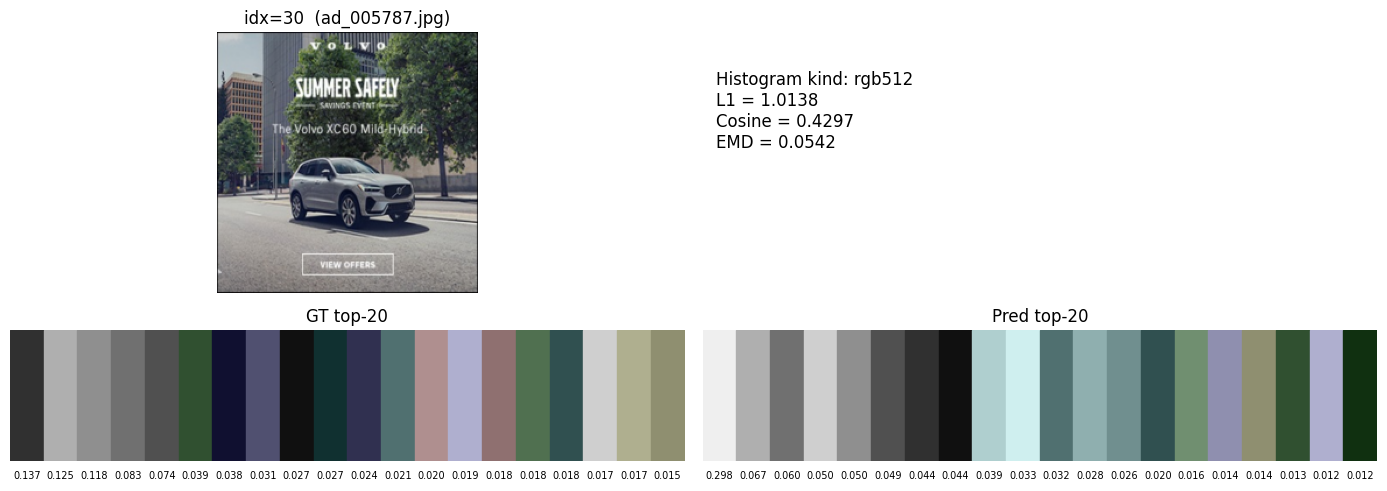

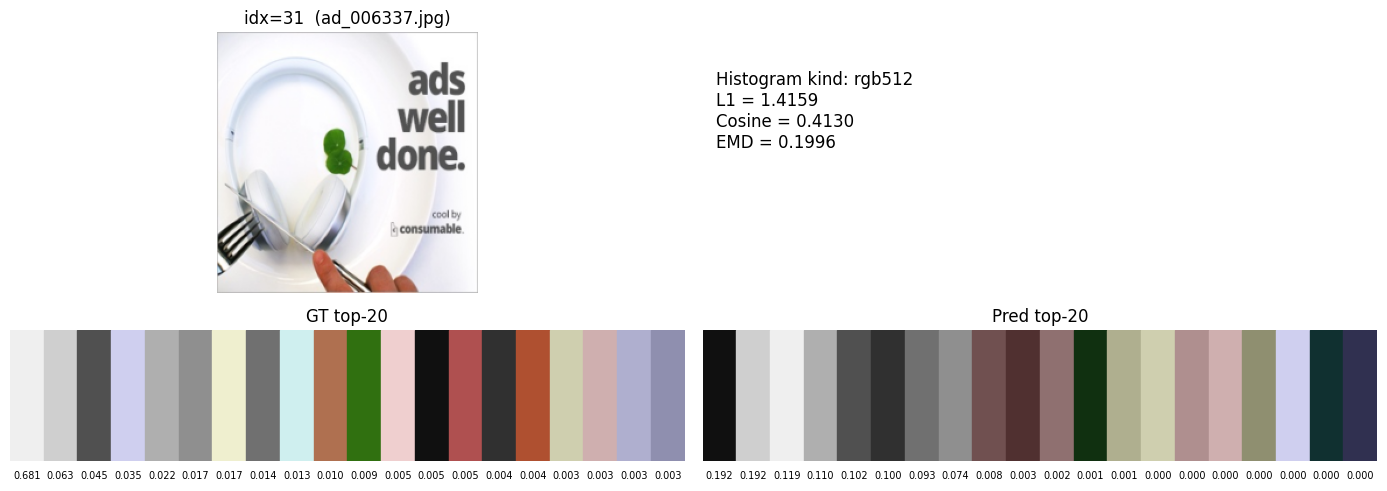

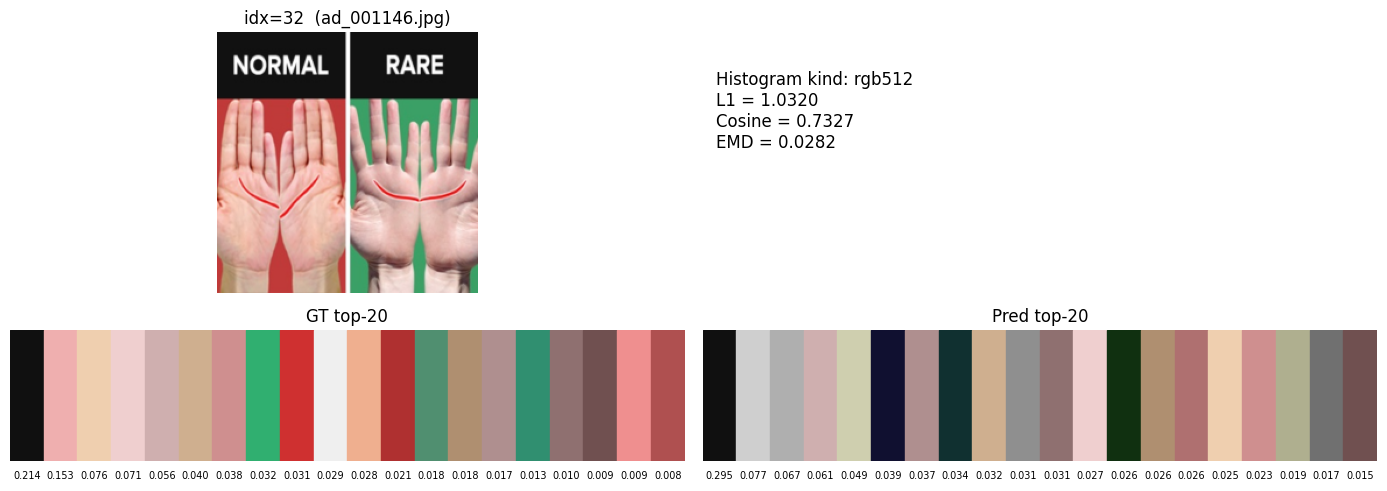

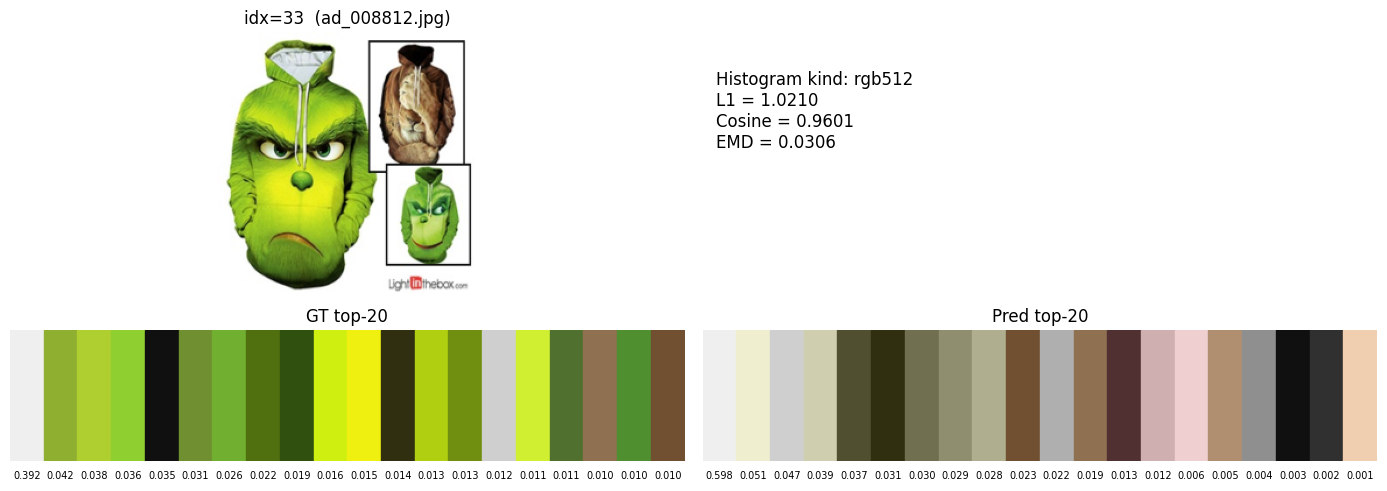

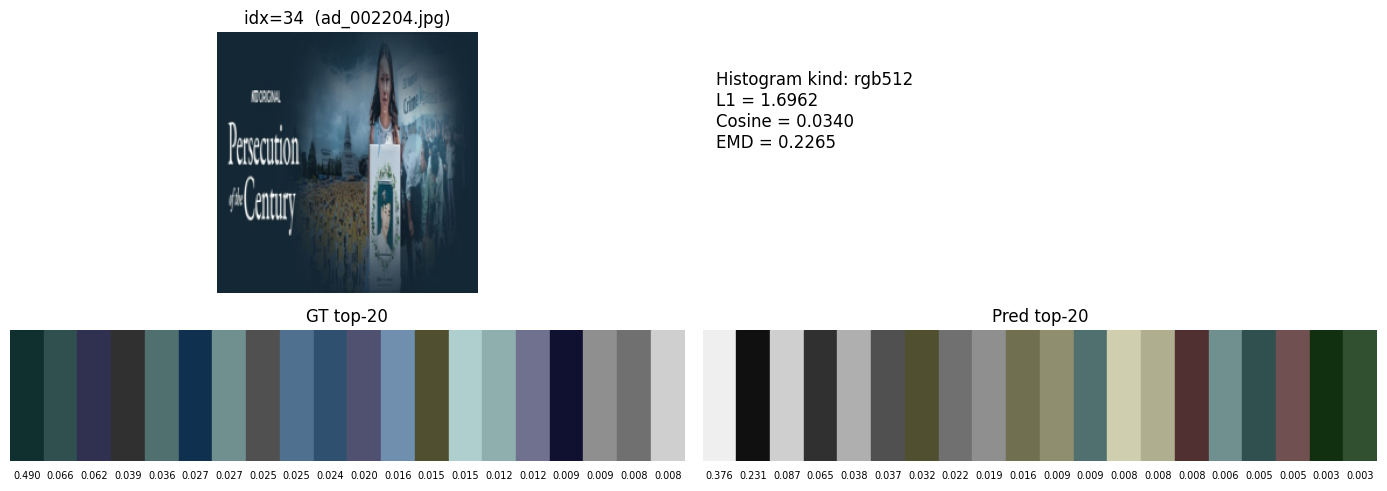

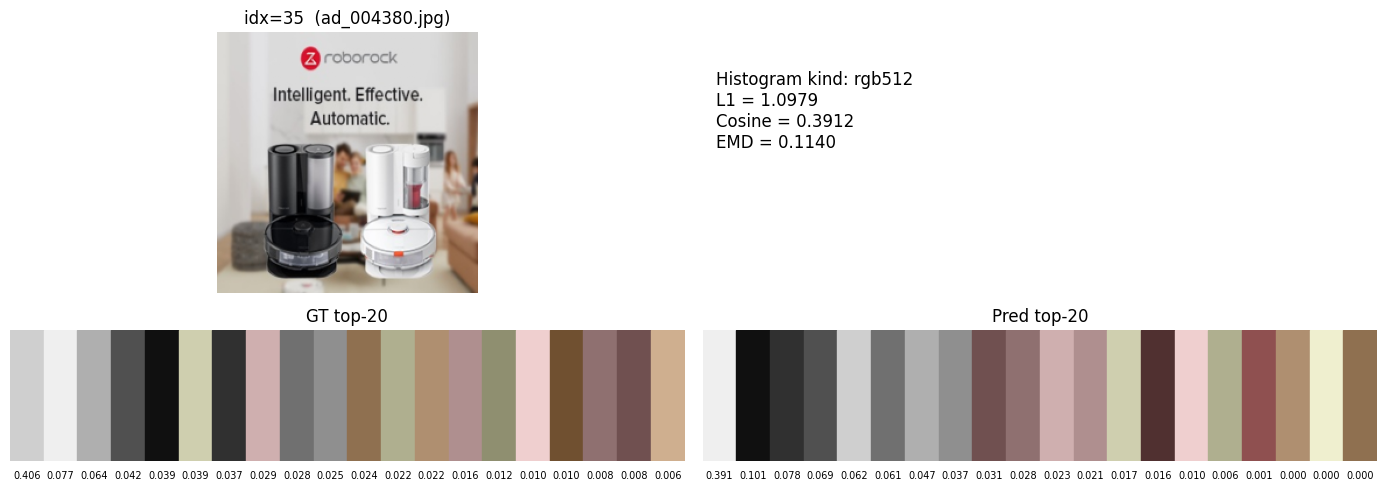

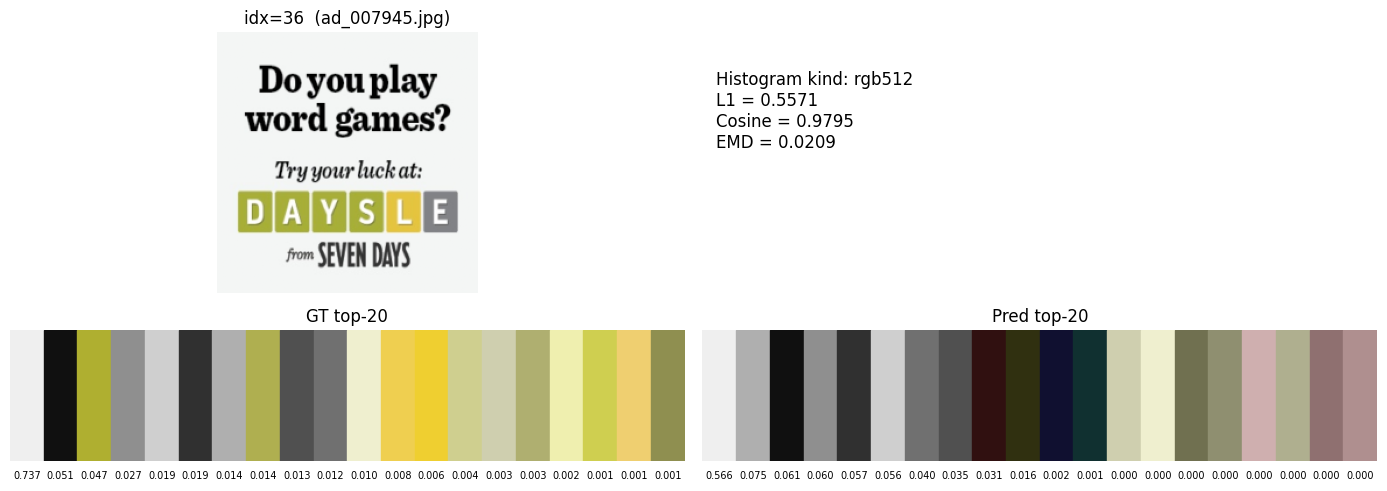

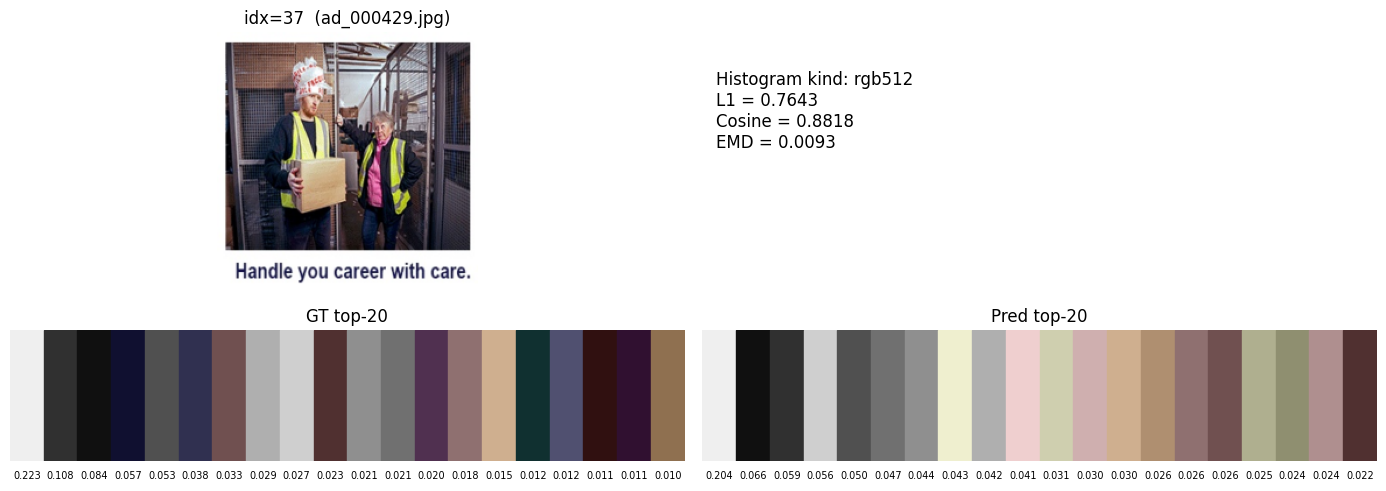

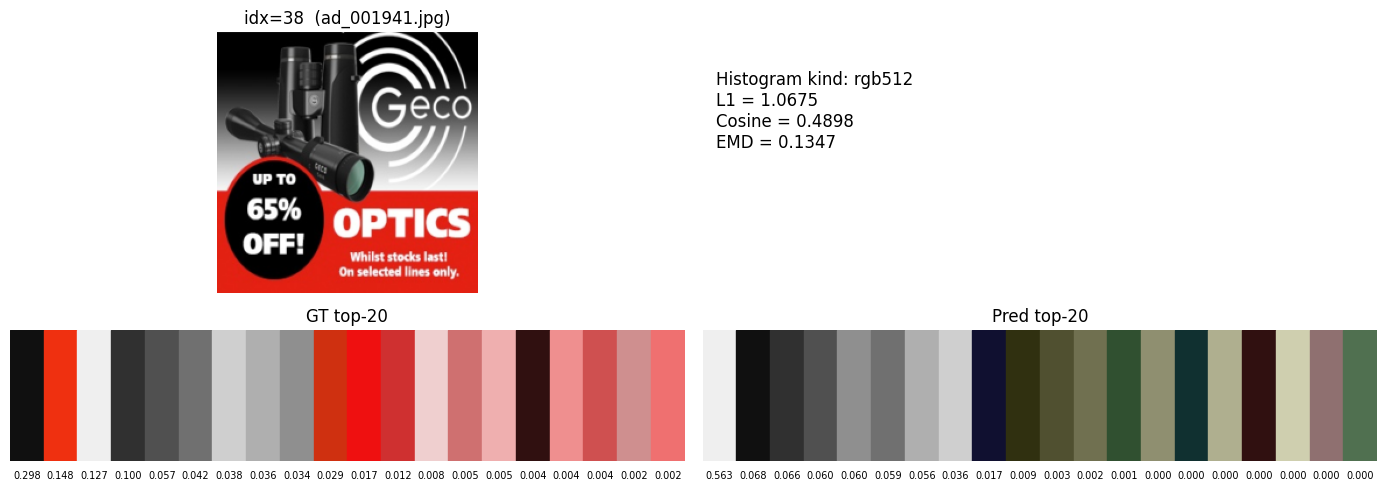

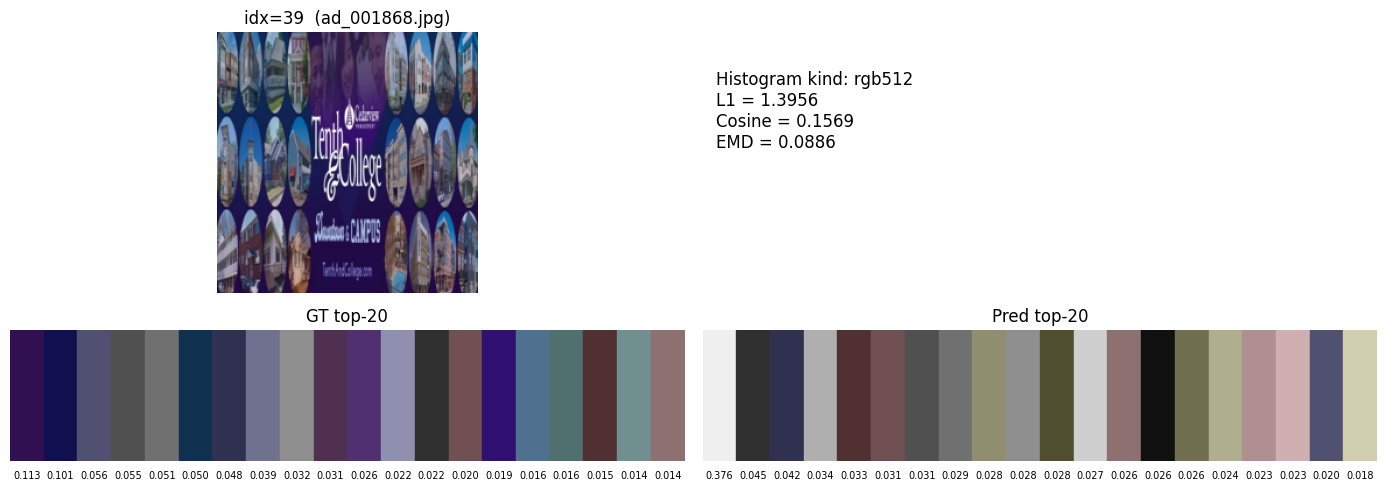

In [19]:
# ==== Aligned GT vs Pred top-20 + IMAGE (first 10) ====
import os, numpy as np, torch, matplotlib.pyplot as plt, pandas as pd
from skimage.color import lab2rgb

import config
from data.dataset import UnifiedImageDataset
from models.color_heads import ColorHead  # your MLP head

# choose the same histogram kind you trained with
HIST_KIND = "rgb512"   # "rgb512" | "lab514" | "hcl514"
BINS      = 8
TOP_K     = 20

# paths
EMB_PATH  = getattr(config, "EMBEDDINGS_TARGET_PATH", getattr(config, "EMBEDDINGS_TARGET_PATH", None))
HIST_PATH = {
    "rgb512": config.COLOR_HIST_PATH_RGB,
    "lab514": config.COLOR_HIST_PATH_LAB_514,
    "hcl514": config.COLOR_HIST_PATH_HCL_514,
}[HIST_KIND]
CSV_PATH  = config.CSV_PATH
CKPT_PATH = "/data/degis/runs/rgb512_tk100_b4096-20250827-232425/best_color_head_tmp.pth"
# CKPT_PATH = "/data/degis/runs/hcl514_tk100_b4096-20250827-222013/best_color_head_tmp_hcl.pth"
# CKPT_PATH = "best_color_head_hcl.pth"
# CKPT_PATH = "best_color_head.pth"
# CKPT_PATH = "/data/degis/runs/xl_laion_5m_rgb512_tk100_b4096-20250828-191628/best_color_head_tmp.pth"
# CKPT_PATH = "/data/degis/runs/xl_laion_5m_lab514_tk100_b4096-20250828-194651/best_color_head_tmp.pth"
# CKPT_PATH = "/data/degis/runs/xl_laion_5m_hcl514_tk100_b4096-20250828-200646/best_color_head_tmp.pth"



# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load arrays (read-only is fine)
emb  = np.load(EMB_PATH,  mmap_mode="r").astype(np.float32, copy=False)
hist = np.load(HIST_PATH, mmap_mode="r").astype(np.float32, copy=False)

# build the SAME dataset ordering you used when generating arrays
df = pd.read_csv(CSV_PATH)
dataset = UnifiedImageDataset(
    df.rename(columns={"local_path":"file_path"}),
    mode="file_df",
    size=(224,224),     # <- must match generation
    subset_ratio=1.0
)

# hard alignment check
assert len(dataset) == emb.shape[0] == hist.shape[0], \
    "Dataset and npy arrays are misaligned — rebuild the dataset EXACTLY like during generation."

# load model
color_head = ColorHead(clip_dim=emb.shape[1], hist_dim=hist.shape[1]).to(device)
color_head.load_state_dict(torch.load(CKPT_PATH, map_location=device))
color_head.eval()

# Optional EMD metric without KeOps (tensorized backend). If unavailable, we just don't show EMD.
try:
    import geomloss
    sinkhorn = geomloss.SamplesLoss("sinkhorn", p=2, blur=0.05, backend="tensorized")
except Exception:
    sinkhorn = None

SPACE = {"rgb512":"rgb", "lab514":"lab", "hcl514":"hcl"}[HIST_KIND]

def _top_palette(vec, bins=BINS, top_k=TOP_K, space=SPACE, c_max=150.0):
    v = vec.detach().cpu().numpy() if isinstance(vec, torch.Tensor) else np.asarray(vec)
    core = v[:bins**3]  # ignore the last 2 BW slots for palette picking
    idxs = np.argsort(core)[-top_k:][::-1]
    cols = []
    if space == "rgb":
        for flat in idxs:
            ri = flat // (bins*bins); gi = (flat // bins) % bins; bi = flat % bins
            cols.append(((ri+0.5)/bins, (gi+0.5)/bins, (bi+0.5)/bins))
    elif space == "lab":
        for flat in idxs:
            Li = flat // (bins*bins); ai = (flat // bins) % bins; bi = flat % bins
            L = (Li+0.5)/bins*100.0
            a = (ai+0.5)/bins*255.0 - 128.0
            b = (bi+0.5)/bins*255.0 - 128.0
            cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
    elif space == "hcl":
        for flat in idxs:
            Li = flat // (bins*bins); Ci = (flat // bins) % bins; Hi = flat % bins
            L = (Li+0.5)/bins*100.0
            C = (Ci+0.5)/bins*c_max
            H = (Hi+0.5)/bins*360.0
            a = C*np.cos(np.deg2rad(H)); b = C*np.sin(np.deg2rad(H))
            cols.append(tuple(lab2rgb(np.array([[[L,a,b]]]))[0,0]))
    else:
        raise ValueError("space must be 'rgb' | 'lab' | 'hcl'")
    return cols, core[idxs]

def _plot_palette(ax, colors, values, title):
    for i, (c, v) in enumerate(zip(colors, values)):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=c))
        ax.text(i+0.5, -0.08, f"{v:.3f}", ha="center", va="top", fontsize=7)
    ax.set_xlim(0, len(colors)); ax.set_ylim(0,1); ax.axis("off")
    ax.set_title(title, fontsize=12)

def show_aligned(i):
    # image from the SAME dataset (guarantees correct ordering)
    img_t, _ = dataset[i]                    # [3,224,224] float [0,1]
    img_np   = img_t.permute(1,2,0).numpy()  # HWC

    # GT and Pred from aligned arrays / model
    h_gt = torch.from_numpy(hist[i]).to(device)
    z    = torch.from_numpy(emb[i]).to(device).unsqueeze(0)

    with torch.no_grad():
        _, p, _ = color_head(z)
        p = p.squeeze(0)
        p = p / (p.sum() + 1e-8)
        g = h_gt / (h_gt.sum() + 1e-8)
        l1  = torch.sum(torch.abs(p-g)).item()
        cos = torch.nn.functional.cosine_similarity(p, g, dim=0).item()
        emd = sinkhorn(p.unsqueeze(0), g.unsqueeze(0)).item() if sinkhorn is not None else None

    gt_cols, gt_vals = _top_palette(g)
    pr_cols, pr_vals = _top_palette(p)

    # draw
    fig, axes = plt.subplots(2, 2, figsize=(14, 5), gridspec_kw={"height_ratios":[2,1]})
    axes[0,0].imshow(img_np); axes[0,0].axis("off")
    basename = os.path.basename(str(dataset.df.iloc[i]["file_path"]))
    axes[0,0].set_title(f"idx={i}  ({basename})")

    axes[0,1].axis("off")
    txt = f"Histogram kind: {HIST_KIND}\nL1 = {l1:.4f}\nCosine = {cos:.4f}"
    if emd is not None: txt += f"\nEMD = {emd:.4f}"
    axes[0,1].text(0.02, 0.85, txt, fontsize=12, va="top")

    _plot_palette(axes[1,0], gt_cols, gt_vals, f"GT top-{TOP_K}")
    _plot_palette(axes[1,1], pr_cols, pr_vals, f"Pred top-{TOP_K}")
    plt.tight_layout(); plt.show()

for i in range(30, 40):
    show_aligned(i)


# Generation

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image

import config  # ✅ will work if notebook is in same folder as config.py
from data.dataset import UnifiedImageDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import os
HF_CACHE = "/data/hf-cache"
os.makedirs(HF_CACHE, exist_ok=True)

os.environ["HF_HOME"] = HF_CACHE
os.environ["HUGGINGFACE_HUB_CACHE"] = os.path.join(HF_CACHE, "hub")
os.environ["TRANSFORMERS_CACHE"]     = os.path.join(HF_CACHE, "transformers")
os.environ["DIFFUSERS_CACHE"]        = os.path.join(HF_CACHE, "diffusers")
os.environ["TORCH_HOME"]             = os.path.join(HF_CACHE, "torch")

In [7]:
from IPython.display import display
from torchvision import transforms
from ip_adapter import IPAdapter
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline

# Create pipeline with ControlNet built-in
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    feature_extractor=None,
    cache_dir=HF_CACHE,
).to(device)

pipe.controlnet = pipe.controlnet.to(dtype=torch.float16)

# Now create IP-Adapter (it will automatically detect the ControlNet)
ip_adapter = IPAdapter(
    sd_pipe=pipe,  # This pipe already has ControlNet integrated
    image_encoder_path="laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    ip_ckpt="/data/thesis/models/ip-adapter_sd15.bin",
    device=device,
    embedding_type='clip'
)

/usr/local/lib/python3.12/dist-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
df = pd.read_csv(config.CSV_PATH)

dataset = UnifiedImageDataset(
    df.rename(columns={"local_path": "file_path"}),
    mode="file_df",
    size=config.IMG_SIZE, 
)

print(df.shape)

In [ ]:
# from IPython.display import display
# from torchvision import transforms
# from ip_adapter import IPAdapter
# import torch

# to_pil = transforms.ToPILImage()

# def display_images(images):
#     for img in images:
#         display(img)

# @torch.no_grad()
# def generate_from_dataset_id(i: int,
#                              prompt: str = "a cat playing with a ball",
#                              guidance_scale: float = 10.0,
#                              steps: int = 50,
#                              controlnet_conditioning_scale: float = 1.0):
#     # 1) Get the original image from your dataset
#     img_t, _ = dataset[i]
#     pil_img = to_pil(img_t)

#     # 2) Get a CLIP image embedding
#     # Prefer precomputed `emb[i]`; fall back to computing via clip_model+preprocess
#     try:
#         z_clip = torch.as_tensor(emb[i], dtype=torch.float32, device=device).unsqueeze(0)  # [1, D]
#     except Exception:
#         assert 'clip_model' in globals() and 'preprocess' in globals(), \
#             "Need `clip_model` and `preprocess` to compute CLIP on the fly."
#         z_clip = clip_model.encode_image(preprocess(pil_img).unsqueeze(0).to(device)).float()


#     _, _, color_map_embedding = color_head(z_clip)  # keep if you want to inspect/log it

#     # 4) Generate from CLIP embedding with IP-Adapter
#     images = ip_adapter.generate_from_embeddings(
#         clip_image_embeds=color_map_embedding,             # <-- use CLIP embedding
#         prompt=prompt,
#         num_samples=1,
#         guidance_scale=guidance_scale,
#         num_inference_steps=steps,            # 30–60 is usually plenty
#         # ---- ControlNet knobs (make layout stronger) ----
#         image=pil_img,                               # control image (your layout/edges)
#         controlnet_conditioning_scale=1.6,           # try 1.2–2.0 for canny/HED
#         control_guidance_start=0.0,                  # apply from the first step
#         control_guidance_end=1.0,                    # …to the last step
#         # guess_mode=False,                            # strongest control
#     )

#     # 5) Display: original then generated
#     display(pil_img)
#     display_images(images)
#     return images

In [ ]:
# --- predicted outlines: load model + visualize GT vs Pred ---
import config

import torch
import numpy as np
import matplotlib.pyplot as plt

from models.color_heads import ColorHead

# where you saved the color head
# CKPT_PATH = "best_color_head_hcl.pth"   # change if needed
CKPT_PATH = "best_color_head_rgb_100.pth"

# embeddings (aligned 1:1 with your CSV/color maps)
EMB_PATH = getattr(config, "EMBEDDINGS_TARGET_PATH",
           getattr(config, "EMBEDDINGS_PATH", None))


assert EMB_PATH is not None, "Please set EMBEDDINGS_TARGET_PATH in config.py"
emb = np.load(EMB_PATH, mmap_mode="r")  # shape: [N, 1024]
# hcl_514 = np.load(config.COLOR_HIST_PATH_HCL_514, mmap_mode="r")
rgb512 = np.load(config.COLOR_HIST_PATH_RGB)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# build & load the model
clip_dim = emb.shape[1]
hist_dim = rgb512.shape[1]
color_head = ColorHead(clip_dim=clip_dim, hist_dim=hist_dim).to(device).eval()
color_head.load_state_dict(torch.load(CKPT_PATH, map_location=device))
# --- load the SAME dataset ordering used when you generated the .npy files ---

In [ ]:
generate_from_dataset_id(i=1,
                         prompt="a cat",
                         guidance_scale=7.5,
                         steps=50,
                         controlnet_conditioning_scale=0.0)

In [ ]:
generate_from_dataset_id(i=16,
                         prompt="a cat",
                         guidance_scale=7.5,
                         steps=50)

In [ ]:
generate_from_dataset_id(i=1008,
                         prompt="a cat",
                         guidance_scale=7.5,
                         steps=75,
                         controlnet_conditioning_scale=2.0)

In [ ]:
generate_from_dataset_id(i=1009,
                         prompt="a cat",
                         guidance_scale=7.5,
                         steps=75)

In [ ]:
generate_from_dataset_id(i=1009,
                         prompt="a dog with balls",
                         guidance_scale=7.5,
                         steps=75)

In [8]:
from PIL import Image
import numpy as np

from PIL import Image, ImageOps
import numpy as np
import torch
import torch.nn.functional as F
to_pil = transforms.ToPILImage()
edges = np.load(config.EDGE_MAPS_PATH, mmap_mode="r")
def display_images(images):
    for img in images:
        display(img)

def _control_edge_pil(i: int, size: int = 512) -> Image.Image:
    """Return a ControlNet-ready edge PIL (RGB, size×size) from cached edges[i]."""
    row = edges[i]  # shape [H*W] (uint8 or float32), memmap ok
    H, W = getattr(config, "IMG_SIZE", (224, 224))
    if row.ndim == 1 and row.shape[0] != H * W:
        side = int(np.sqrt(row.shape[0])); H = W = side
    edge = row.reshape(H, W)
    if edge.dtype != np.uint8:
        edge = (edge * 255.0).clip(0, 255).astype(np.uint8)
    pil = Image.fromarray(edge)                          # grayscale
    pil = ImageOps.autocontrast(pil)                     # just to visualize better
    pil = pil.resize((size, size), Image.BILINEAR).convert("RGB")  # ControlNet likes RGB
    return pil


@torch.no_grad()
def generate_from_dataset_id(i: int,
                             prompt: str = "a cat playing with a ball",
                             guidance_scale: float = 0.0,
                             steps: int = 30,
                             controlnet_conditioning_scale: float = 0.0,
                             num_samples: int = 1):
    # 1) dataset image (only for display)
    img_t, _ = dataset[i]
    pil_img = to_pil(img_t)

    # 2) CLIP embedding (prefer precomputed)
    try:
        z_clip = torch.as_tensor(emb[i], dtype=torch.float32, device=device).unsqueeze(0)  # Keep as float32
    except Exception:
        z_clip = clip_model.encode_image(preprocess(pil_img).unsqueeze(0).to(device)).float()  # Keep as float32

    # (optional) you can still compute color_map_embedding if you need it elsewhere
    _, _, color_map_embedding = color_head(z_clip)  # color_head works with float32


    # ControlNet edge image from cached edges
    control_pil = _control_edge_pil(i, size=512)

    # 4) Generate from CLIP embedding with IP-Adapter
    images = ip_adapter.generate_from_embeddings(
        clip_image_embeds=color_map_embedding.to(dtype=torch.float16),  # Convert to float16 for IP-Adapter
        prompt=prompt,
        num_samples=num_samples,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,            # 30–60 is usually plenty
        # ---- ControlNet knobs (make layout stronger) ----
        image=control_pil,                               # control image (your layout/edges)
        controlnet_conditioning_scale=controlnet_conditioning_scale,           # try 1.2–2.0 for canny/HED
        control_guidance_start=0.0,                  # apply from the first step
        # control_guidance_end=10.0,                    # …to the last step
        # guess_mode=False,                            # strongest control
    )

    display(pil_img)          # original
    display(control_pil)
    display_images(images)    # generated
    return images

  0%|          | 0/100 [00:00<?, ?it/s]

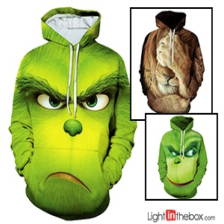

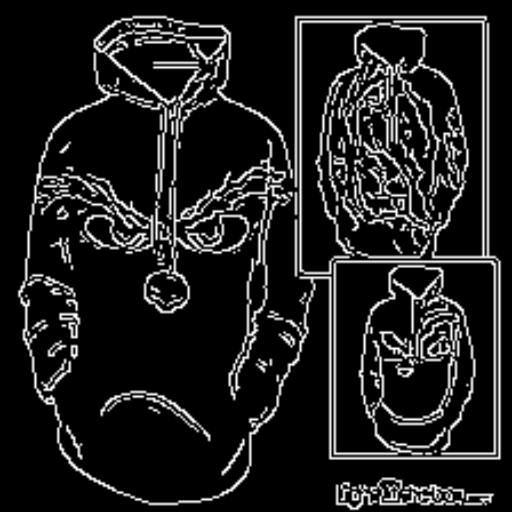

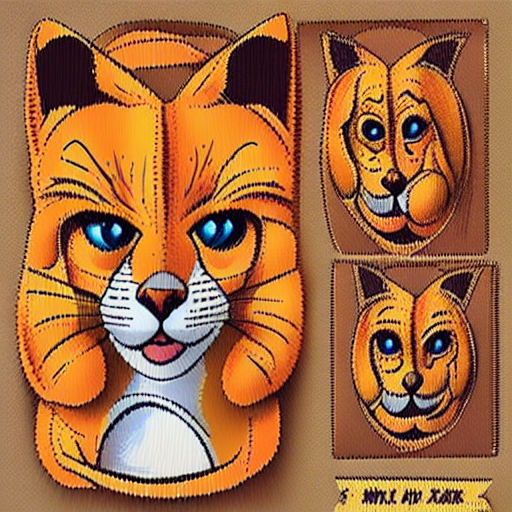

[<PIL.Image.Image image mode=RGB size=512x512>]

In [36]:
generate_from_dataset_id(i=33,
                         prompt="an ad oof a cat on a tshirt",
                         guidance_scale=7.5,
                         steps=100,
                         controlnet_conditioning_scale=0.8,
                         num_samples=1)

In [ ]:
generate_from_dataset_id(i=1008,
                        prompt="a dog",
                        guidance_scale=7.5,
                        steps=50,
                        controlnet_conditioning_scale=0.1,
                        num_samples=1)